In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import json
import os
import random
from glob import glob

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from PIL import Image
from PIL import ImageDraw
from torch.utils.data import DataLoader
from tqdm import tqdm, auto
from transformers import (
    Mask2FormerForUniversalSegmentation,
    Mask2FormerImageProcessor,
    MaskFormerImageProcessor,
)
from datasets import Dataset, DatasetDict, load_from_disk
from IPython.display import display

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ---------- ① モデル/プロセッサをロード ----------
MODEL_DIR = "/content/drive/MyDrive/KKG/models/foundation/mask2former_best_202506010842"            # ★保存先を合わせる
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Mask2FormerForUniversalSegmentation.from_pretrained(MODEL_DIR).to(device)
processor = Mask2FormerImageProcessor.from_pretrained(
    MODEL_DIR,
    reduce_labels=True,
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30990 (\N{CJK UNIFIED IDEOGRAPH-790E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22259 (\N{CJK UNIFIED IDEOGRAPH-56F3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fi

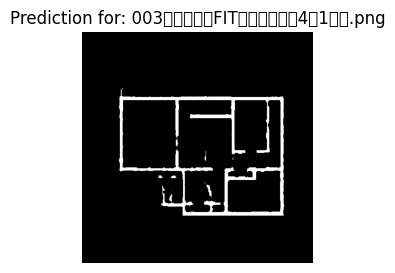

[003　基礎図　FIT新座市野火止4期1号棟.png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27083 (\N{CJK UNIFIED IDEOGRAPH-69CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36896 (\N{CJK UNIFIED IDEOGRAPH-9020}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  fig.canvas.print_

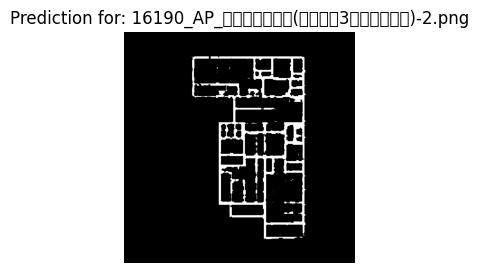

[16190_AP_構造図・標準図(川口並木3丁目共同住宅)-2.png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12383 (\N{HIRAGANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, *

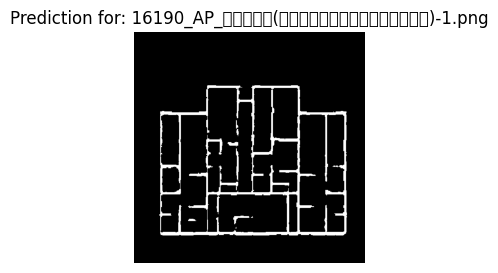

[16190_AP_構造図一式(さいたま市見沼区東門前共同住宅)-1.png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26494 (\N{CJK UNIFIED IDEOGRAPH-677E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24314 (\N{CJK UNIFIED IDEOGRAPH-5EFA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35373 (\N{CJK UNIFIED IDEOGRAPH-8A2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  fig.canvas

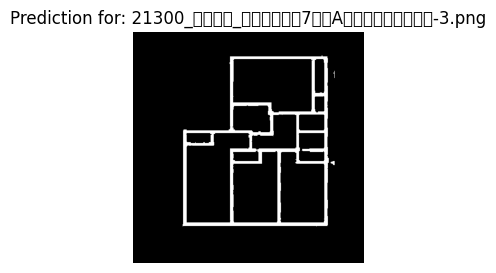

[21300_松和建設_練馬区東大泉7丁目A棟壁量計算・基礎図-3.png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65343 (\N{FULLWIDTH LOW LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33455 (\N{CJK UNIFIED IDEOGRAPH-82AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, *

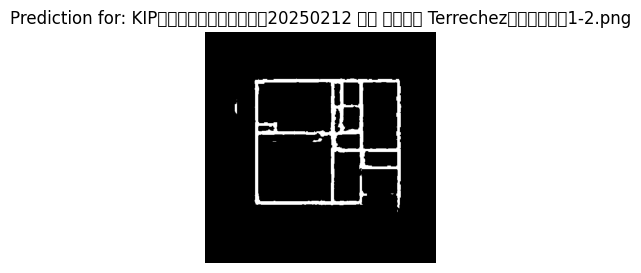

[KIP＿芯線ありすぎ問題）20250212 変更 基礎伏図 Terrechez瀬戸市八幡台1-2.png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12431 (\N{HIRAGANA LETTER WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


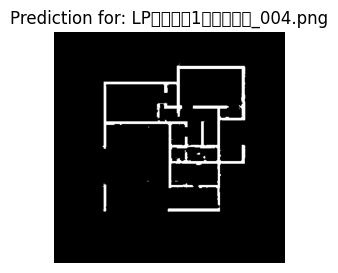

[LPときわ台1号棟構造図_004.png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26360 (\N{CJK UNIFIED IDEOGRAPH-66F8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12305 (\N{RIGHT BLACK LENTICULAR BRACKET}) missing from font(s) DejaVu Sans.
  fig

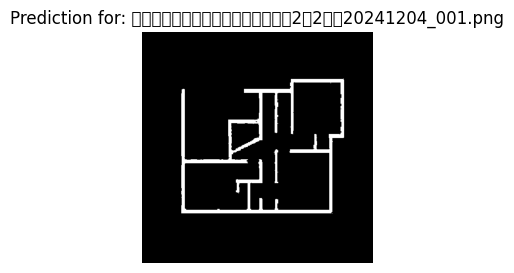

[【確定図書】【構造図】小金井本町2　2号棟20241204_001.png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12527 (\N{KATAKANA LETTER WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

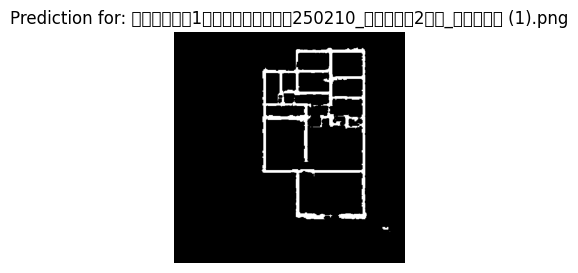

[リアワークス1＿人通口変わり種）250210_杉並区宮前2丁目_構造図一式 (1).png]
segments_info len: 1
label_id set     : {0}
unique seg values: [-1.  0.]
----------------------------------------


In [18]:
# すべてのクラスラベルを1つのマスクに統合する関数
def combine_all_classes(results):
    """
    すべてのセグメントを1つのマスクに統合する。
    """
    segmentation = results['segmentation'].cpu().numpy()
    unified_mask = np.zeros_like(segmentation, dtype=bool)

    # セグメントを統合
    for segment in results['segments_info']:
        segment_mask = (segmentation == segment['id'])
        unified_mask |= segment_mask  # 全体のマスクに統合

    # 統合マスクを画像形式に変換
    unified_mask_image = Image.fromarray((unified_mask * 255).astype(np.uint8))

    return unified_mask_image


def preprocess(image_path: str) -> dict:
    """
    Preprocess CAD image and convert it to a format suitable for line detection

    Parameters:
    -----------
    image_path : str
        Path to input image

    Returns:
    --------
    dict : Dictionary containing preprocessed image and intermediate results
    """
    # Load image
    original = cv2.imread(image_path)
    if original is None:
        raise FileNotFoundError(f'Could not load image: {image_path}')

    # Convert to grayscale
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

    # Contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(gray)

    # Binarization
    _, binary = cv2.threshold(
        contrast_enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
    )

    return {
        'original': cv2.cvtColor(original, cv2.COLOR_BGR2RGB),
        'gray': gray,
        'binary': binary,
    }


# --- Settings ---
INPUT_DIR = "/content/drive/MyDrive/KKG/_input/project-amhard/annotation_data/test"
IMAGE_PATHS = sorted(glob(os.path.join(INPUT_DIR, "*.png")))
OUTPUT_DIR = "/content/inference_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Albumentations transform (same as val_transform) ---
val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Loop over each image ---
for path in IMAGE_PATHS:
    # pre = preprocess(path)
    # binary_rgb = cv2.cvtColor(pre["binary"], cv2.COLOR_GRAY2RGB)  # (H, W, 3)
    # img_np = binary_rgb  # Use the binarized image for inference
    img_pil = Image.open(path).convert("RGB")
    img_np = np.array(img_pil)
    h, w = img_np.shape[:2]

    transformed = val_transform(image=img_np)
    img_normed = transformed["image"].transpose(2, 0, 1)  # HWC ➝ CHW
    img_tensor = torch.tensor(img_normed).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(pixel_values=img_tensor)

    result = processor.post_process_instance_segmentation(outputs, target_sizes=[(512, 512)])[0]
    mask = combine_all_classes(result)

    mask_resized = mask.resize((w, h), resample=Image.NEAREST)

    # Convert original image to RGBA
    img_overlay = img_pil.convert("RGBA")
    overlay_mask = mask_resized.convert("L")  # Grayscale

    # Create an RGBA version of the blue mask
    blue_mask = Image.new("RGBA", img_overlay.size, (0, 0, 255, 128))  # Blue with 50% transparency

    # Composite only where mask is non-zero
    img_with_overlay = Image.composite(blue_mask, img_overlay, overlay_mask)

    # Blend original and mask overlay
    blended = Image.alpha_composite(img_overlay, img_with_overlay)

    # Save outputs
    output_path = os.path.join(OUTPUT_DIR, os.path.basename(path).replace(".png", "_mask.png"))
    blended.save(output_path)

    # ---- Show or save ----
    plt.figure(figsize=(7, 3))
    plt.imshow(mask, cmap="gray")
    plt.title(f"Prediction for: {os.path.basename(path)}")
    plt.axis("off")
    plt.show()

    print(f"[{os.path.basename(path)}]")
    print("segments_info len:", len(result["segments_info"]))
    print("label_id set     :", {s["label_id"] for s in result["segments_info"]})
    print("unique seg values:", np.unique(result["segmentation"]))
    print("-" * 40)


In [19]:
!zip inference_output.zip -r inference_output

  adding: inference_output/ (stored 0%)
  adding: inference_output/LPときわ台1号棟構造図_004_mask.png (deflated 11%)
  adding: inference_output/【確定図書】【構造図】小金井本町2　2号棟20241204_001_mask.png (deflated 10%)
  adding: inference_output/003　基礎図　FIT新座市野火止4期1号棟_mask.png (deflated 11%)
  adding: inference_output/KIP＿芯線ありすぎ問題）20250212 変更 基礎伏図 Terrechez瀬戸市八幡台1-2_mask.png (deflated 8%)
  adding: inference_output/16190_AP_構造図一式(さいたま市見沼区東門前共同住宅)-1_mask.png (deflated 9%)
  adding: inference_output/16190_AP_構造図・標準図(川口並木3丁目共同住宅)-2_mask.png (deflated 9%)
  adding: inference_output/21300_松和建設_練馬区東大泉7丁目A棟壁量計算・基礎図-3_mask.png (deflated 9%)
  adding: inference_output/リアワークス1＿人通口変わり種）250210_杉並区宮前2丁目_構造図一式 (1)_mask.png (deflated 9%)


In [ ]:
import gc
del model, processor
gc.collect()
torch.cuda.empty_cache()

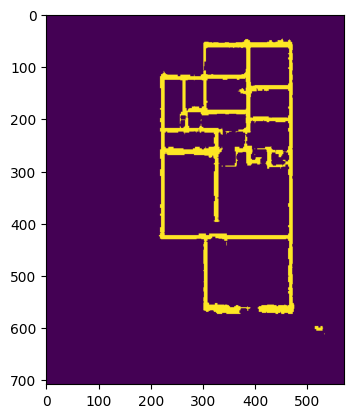

In [15]:
plt.imshow(mask_resized)

In [17]:
np.unique(mask_resized, return_counts=True)

(array([  0, 255], dtype=uint8), array([378270,  25290]))